In [1]:
%matplotlib inline

Import data

In [2]:
import glob

def get_files(root: str, pattern: str) -> list[str]:
    return glob.glob(root + pattern)

timer_data_path = "timer/"
timer_format = "timer_*.log"

timer_files = get_files(timer_data_path, timer_format)
print(timer_files)

['timer\\timer_0.log', 'timer\\timer_1.log', 'timer\\timer_2.log', 'timer\\timer_3.log', 'timer\\timer_4.log', 'timer\\timer_5.log']


Process file

In [3]:
import pandas as pd

def read_timer_file(file: str) -> pd.DataFrame:
    return pd.read_csv(
        file, sep="\s+", header=None, names=["interval", "section", "start", "end"]
    )

timer_data = [read_timer_file(file) for file in timer_files]
print(timer_data[0])

     interval           section               start                 end
0           1         Inbetween  218285686526866430  218285721600110976
1           2    ForwardPacking  218285760794265710  218285760839085332
2           2      ForwardIsend  218285760839641956  218285760884347008
3           2       ForwardRecv  218285760884901882  218285762734697064
4           2  ForwardUnpacking  218285762734818306  218285762771810390
..        ...               ...                 ...                 ...
539        72         Inbetween  218290691379291600  218290723115995178
540        72    ReversePacking  218290723116570128  218290723142823968
541        72      ReverseIsend  218290723142890850  218290723162571686
542        72       ReverseRecv  218290723162632438  218290723190713306
543        72  ReverseUnpacking  218290723190771802  218290723213190978

[544 rows x 4 columns]


In [4]:
import numpy as np

def compute_durations(data: pd.DataFrame) -> pd.DataFrame:
    # Createa a duration column
    data["duration"] = np.nan
    # If start is greater than end, it means that the timer has wrapped around the maximum value 2^64
    # We need to add 2^64 to the end time to get the correct duration
    for i in range(len(data)):
        if data["start"][i] > data["end"][i]:
            data.loc[i, "duration"] = 2**64 + data.loc[i, "end"] - data.loc[i, "start"]
        else:
            data.loc[i, "duration"] = data.loc[i, "end"] - data.loc[i, "start"]
    return data

timer_data = [compute_durations(data) for data in timer_data]
print(timer_data[0]["duration"])

0      3.507324e+10
1      4.481962e+07
2      4.470505e+07
3      1.849795e+09
4      3.699208e+07
           ...     
539    3.173670e+10
540    2.625384e+07
541    1.968084e+07
542    2.808087e+07
543    2.241918e+07
Name: duration, Length: 544, dtype: float64


In [5]:
import pandas as pd
import numpy as np


def prepare_data(data: list[pd.DataFrame], section: str) -> np.ndarray:
    # Collect data for the specified section
    nproc = len(data)
    nintervals = data[0]["interval"].max()
    data_array = np.full((nproc, nintervals), np.nan)
    for i in range(len(data)):
        section_data = data[i][data[i]["section"] == section]
        for j in range(len(section_data)):
            interval = section_data.iloc[j]["interval"] - 1
            processor = i
            duration = section_data.iloc[j]["duration"]
            data_array[processor, interval] = duration
    return data_array

# Gather data for all sections
sections = timer_data[0]["section"].unique()
data_arrays = {section: prepare_data(timer_data, section) for section in sections}

# Print the first data array
print(data_arrays[sections[0]])

[[3.50732445e+10 3.56156830e+10 3.33096140e+10 3.28925239e+10
  3.29980411e+10 3.31092961e+10 3.36233791e+10 3.37956114e+10
  3.45709826e+10 3.53002744e+10 2.76919209e+10 2.98985907e+10
  3.21617416e+10 3.20940423e+10 3.13189095e+10 3.16054192e+10
  3.19024070e+10 3.19435439e+10 3.19760452e+10 3.23601064e+10
  3.26026664e+10 3.26754546e+10 3.26460878e+10 3.24221307e+10
  3.25595343e+10 3.28725084e+10 3.34718006e+10 3.40374819e+10
  3.33188131e+10 3.26086193e+10 3.24041474e+10 3.27553001e+10
  3.14071686e+10 2.94039968e+10 2.81114425e+10 2.71506010e+10
  3.38083512e+10 3.33295627e+10 3.34763781e+10 3.32259062e+10
  3.31653359e+10 3.29822830e+10 3.30728211e+10 2.65064149e+10
  2.78510794e+10 3.07993567e+10 3.22146413e+10 3.28044296e+10
  3.21003754e+10 3.19935552e+10 3.21903800e+10 3.25198994e+10
  3.24350621e+10 3.23047779e+10 3.25339827e+10 3.22322223e+10
  3.22457294e+10 3.23439433e+10 3.22282566e+10 3.22156096e+10
  3.25762950e+10 3.26228656e+10 3.30565038e+10 3.31087290e+10
  3.2497

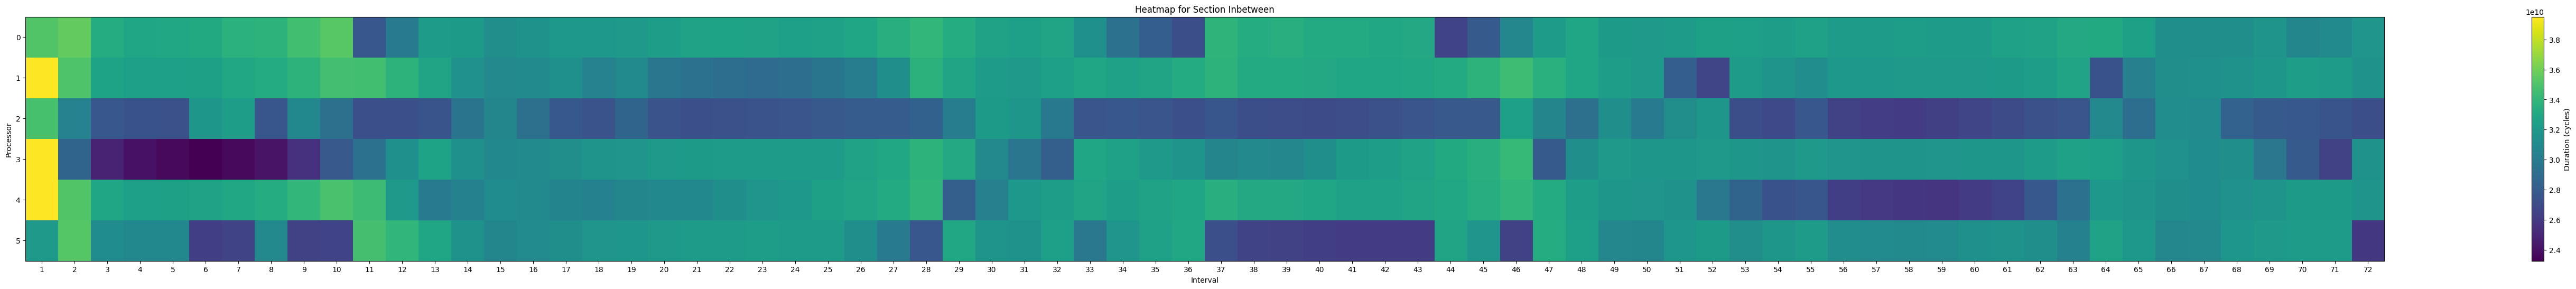

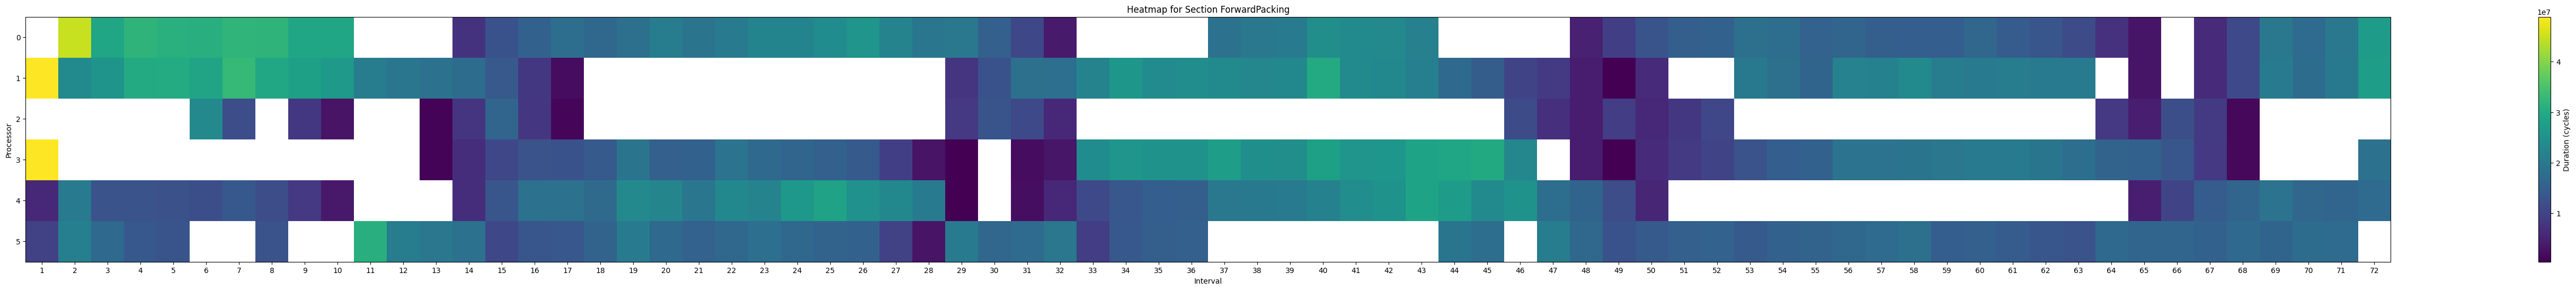

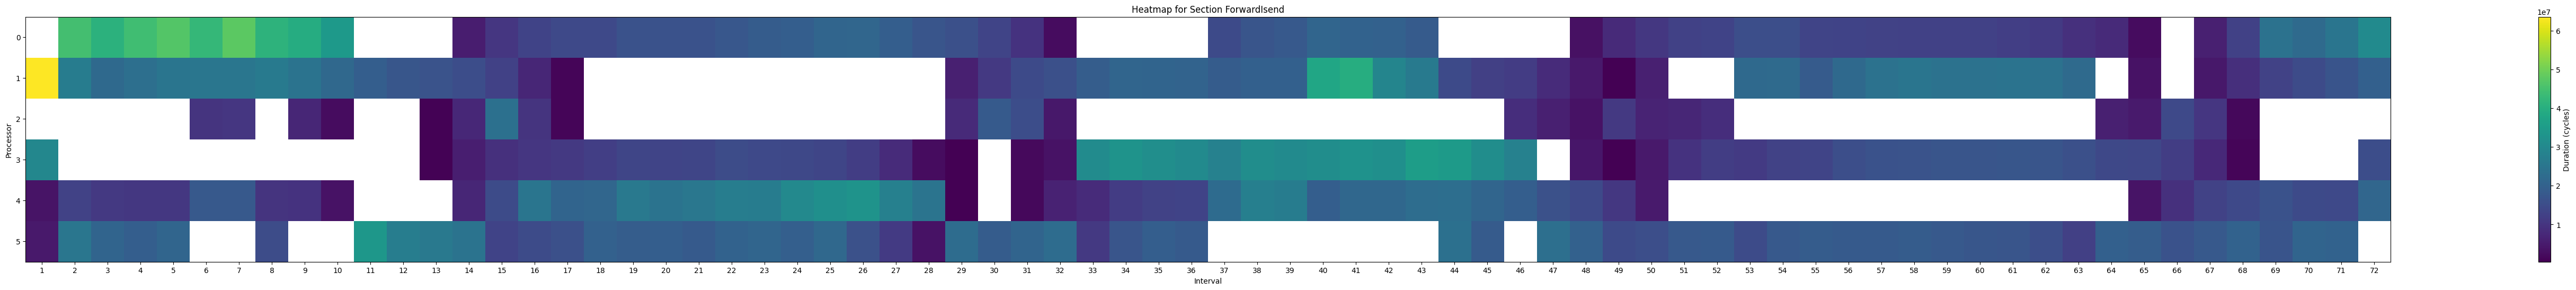

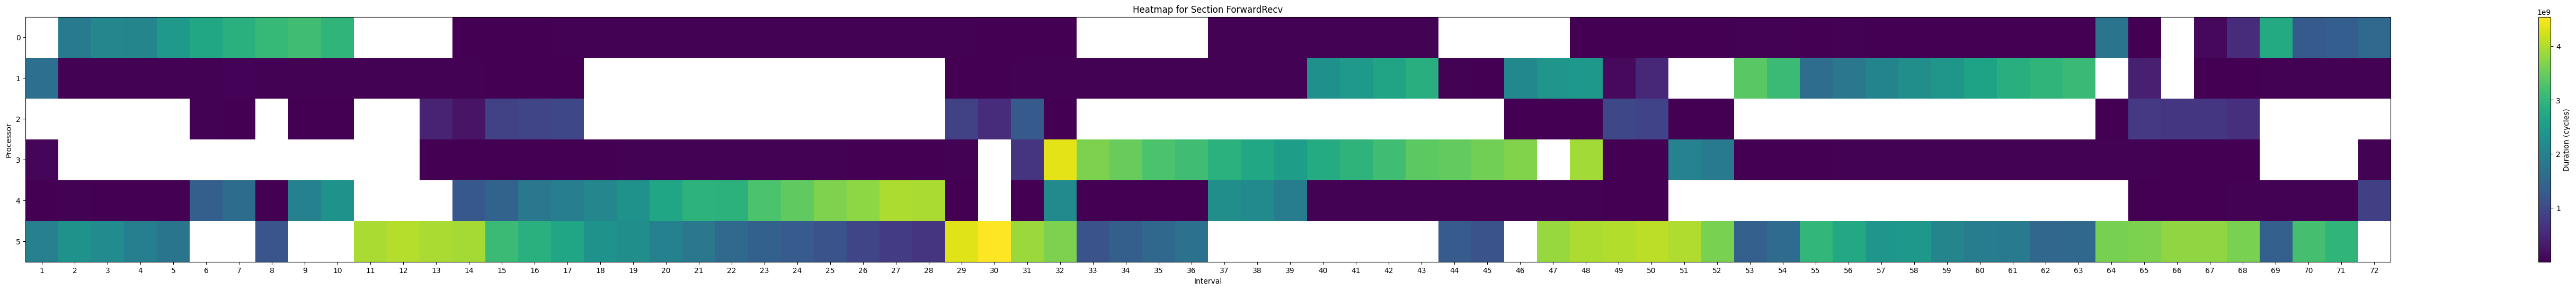

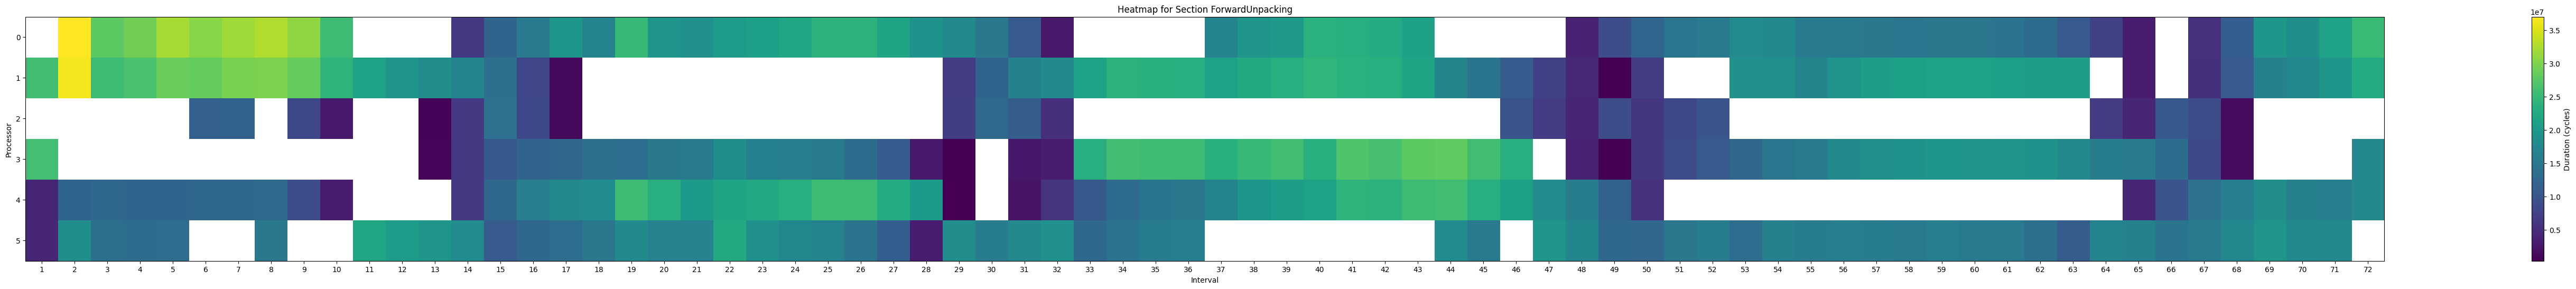

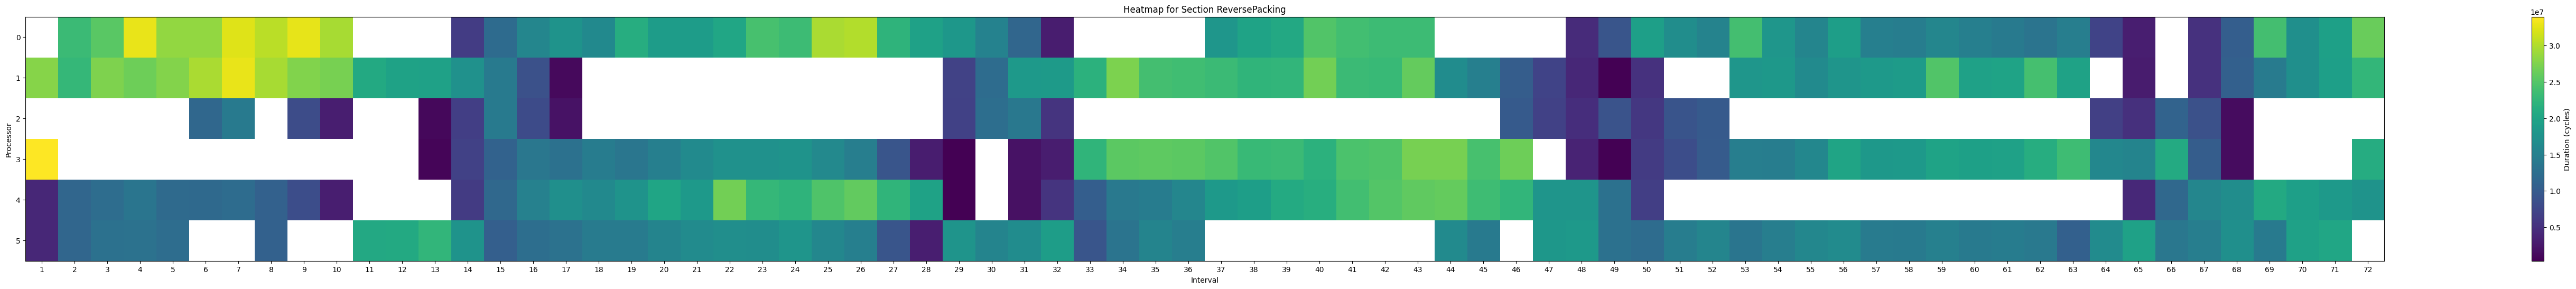

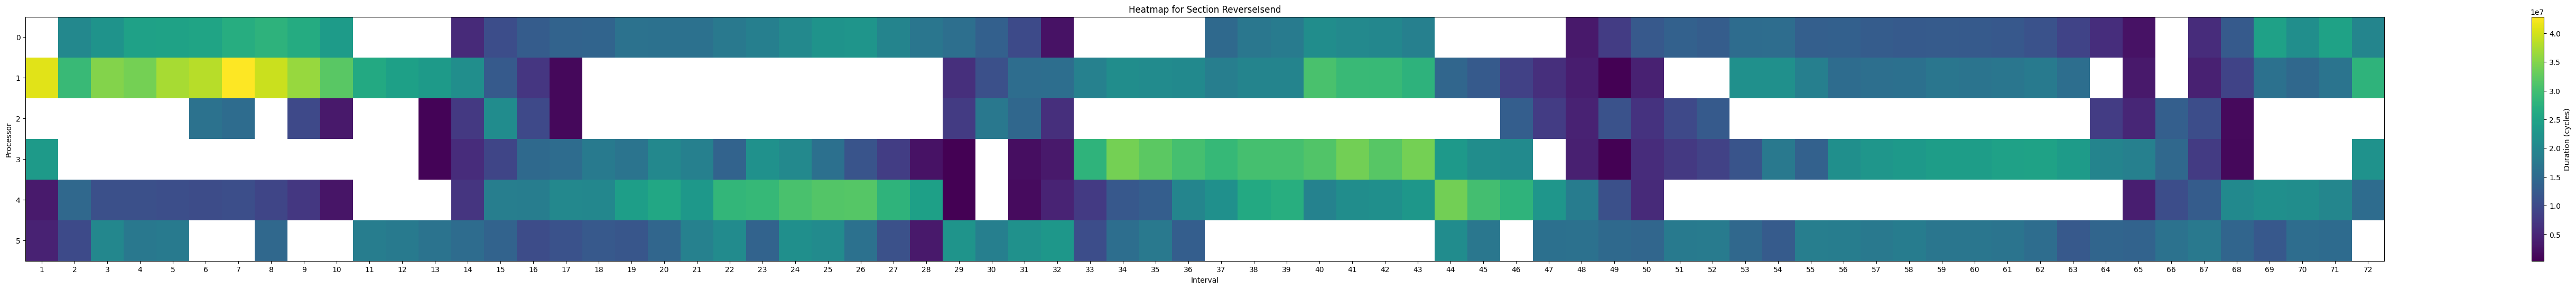

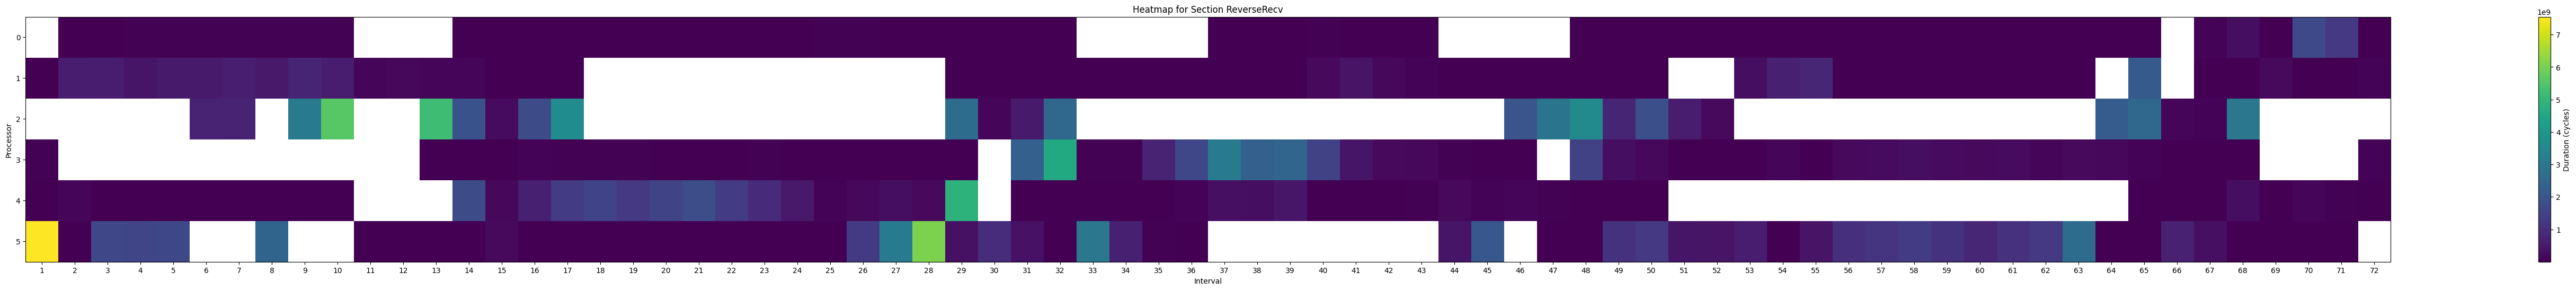

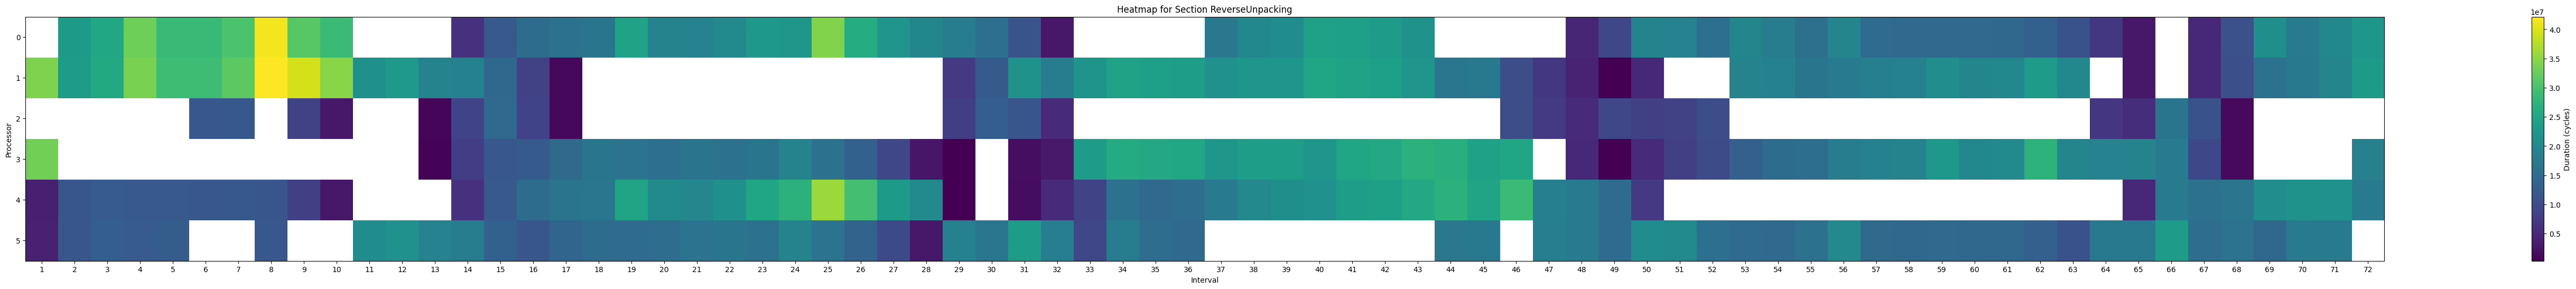

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heatmap(array: np.array, section: str, path: str = None):
    nproc, nintervals = array.shape
    # Create heatmap
    plt.figure(figsize=(nintervals, nproc))
    cax = plt.imshow(
        array,
        cmap="viridis",
        aspect="auto",
    )
    plt.colorbar(cax, label="Duration (cycles)")
    plt.xlabel("Interval")
    plt.ylabel("Processor")
    plt.title(f"Heatmap for Section {section}")
    plt.xticks(ticks=range(nintervals), labels=range(1, nintervals + 1))
    plt.yticks(ticks=range(nproc), labels=range(nproc))
    if path:
        plt.savefig(f"{path}/{section}.png")
        plt.savefig(f"{path}/{section}.eps")

# Save all heatmaps to files
for section in sections:
    os.makedirs("heatmaps", exist_ok=True)
    fig = plot_heatmap(data_arrays[section], section, path="heatmaps")

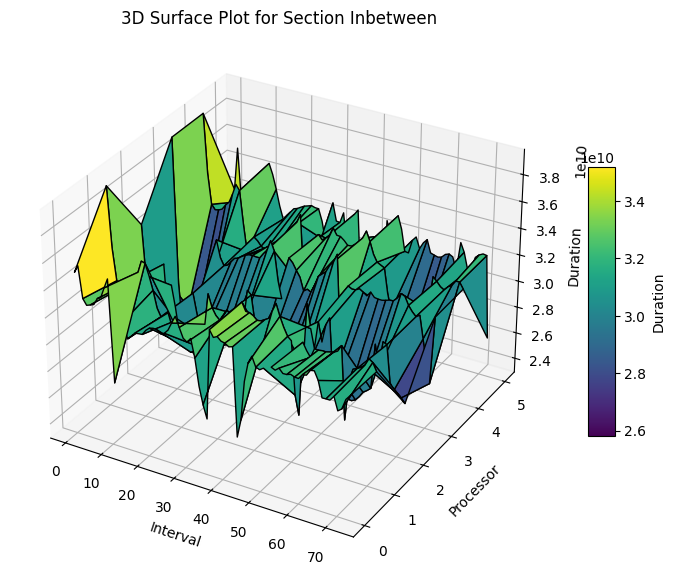

In [7]:
def plot_3d_surface(array: np.array, section: str):
    nproc, nintervals = array.shape
    # Create meshgrid for processors and intervals
    X, Y = np.meshgrid(range(1, nintervals + 1), range(nproc))
    Z = array

    # Plot the surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")

    # Labels and title
    ax.set_xlabel("Interval")
    ax.set_ylabel("Processor")
    ax.set_zlabel("Duration")
    ax.set_title(f"3D Surface Plot for Section {section}")

    # Colorbar
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label="Duration")

    plt.show()


# Example usage for the first section
plot_3d_surface(data_arrays[sections[0]], sections[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

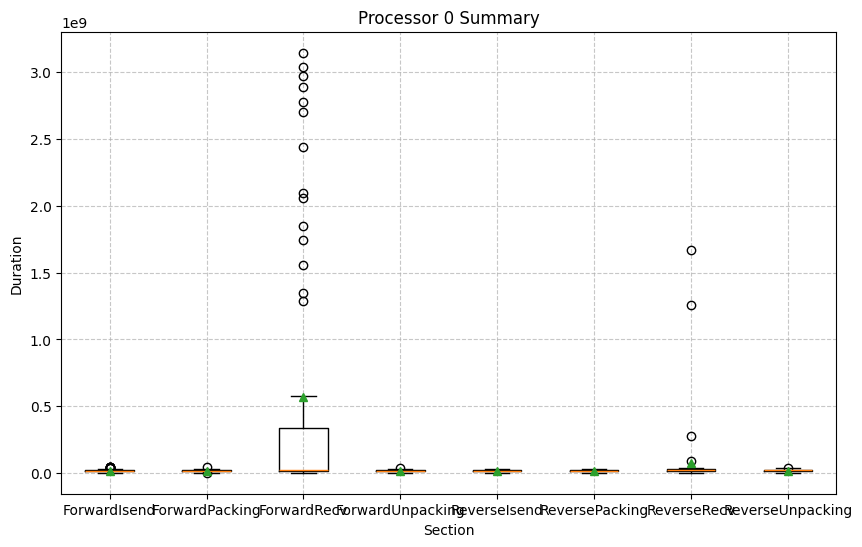

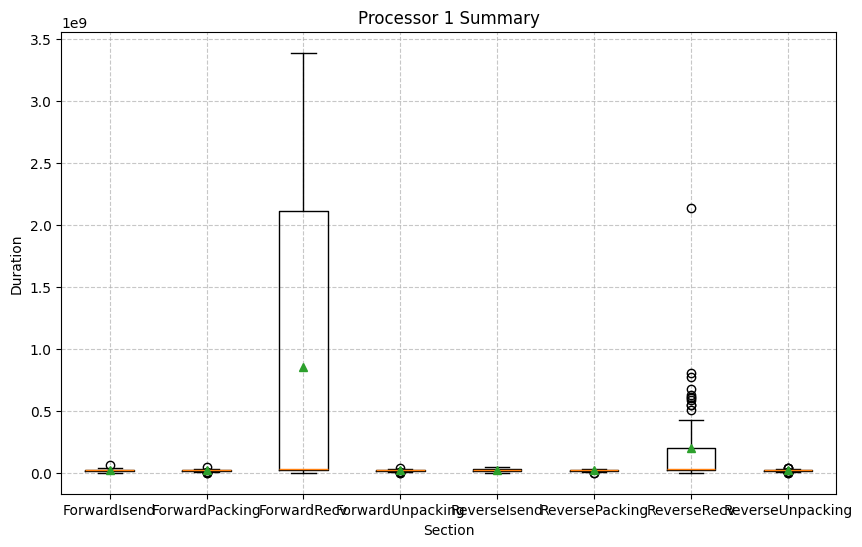

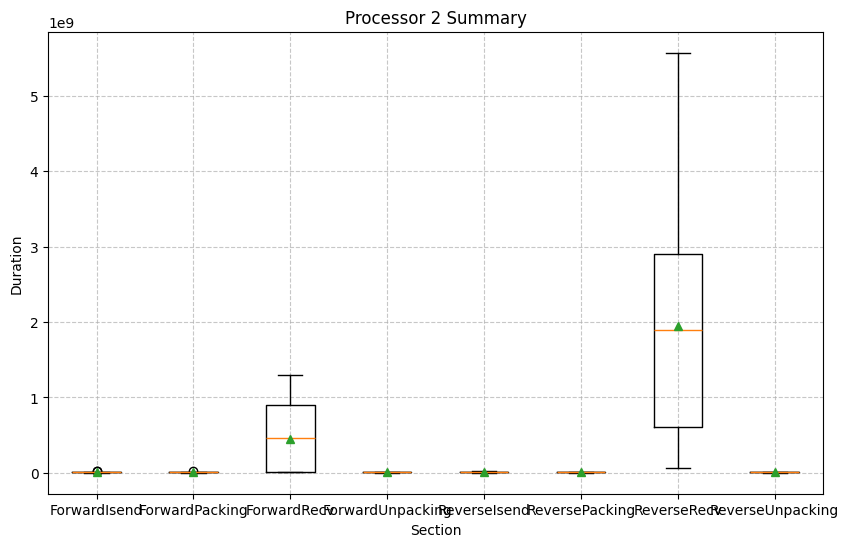

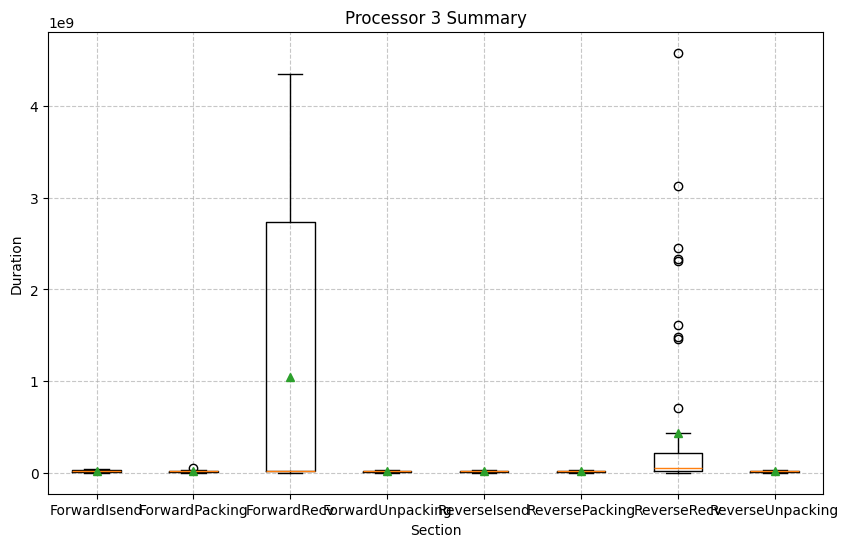

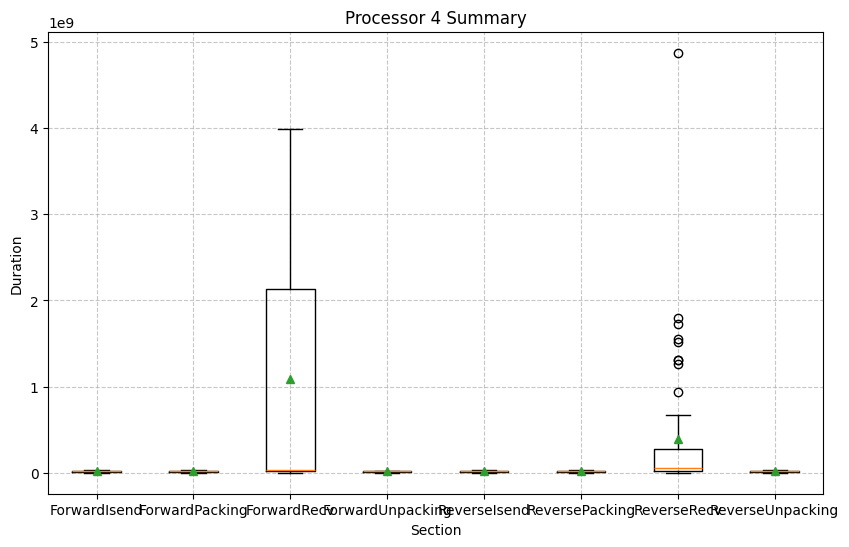

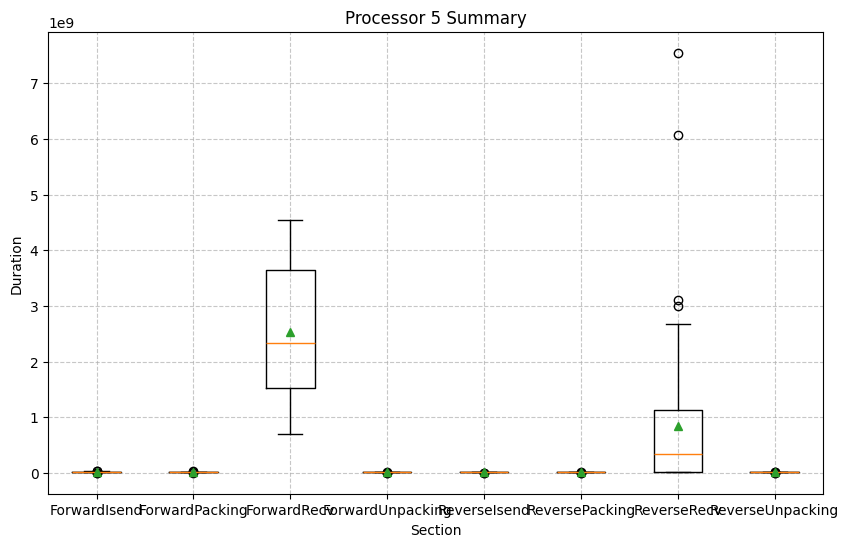

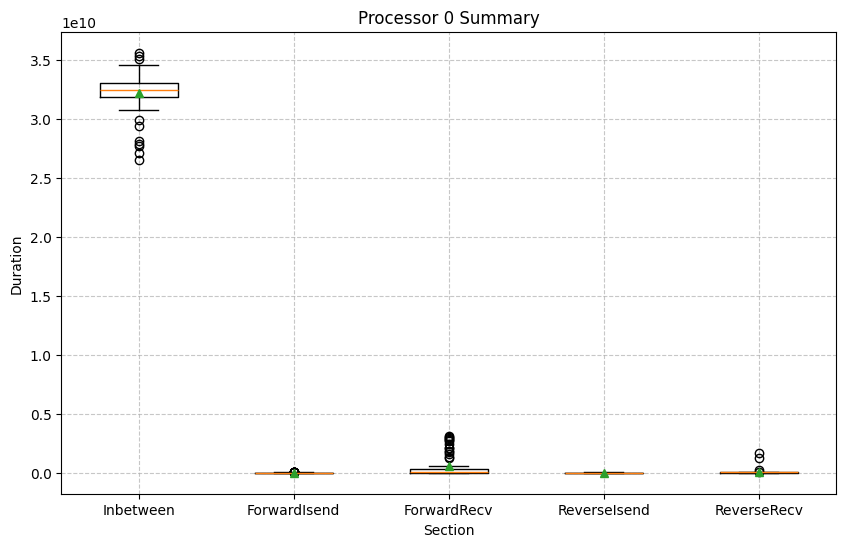

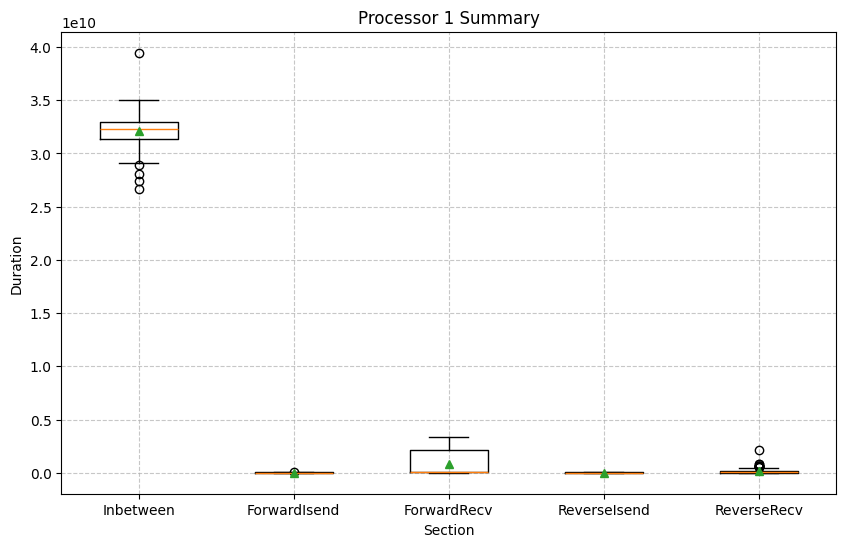

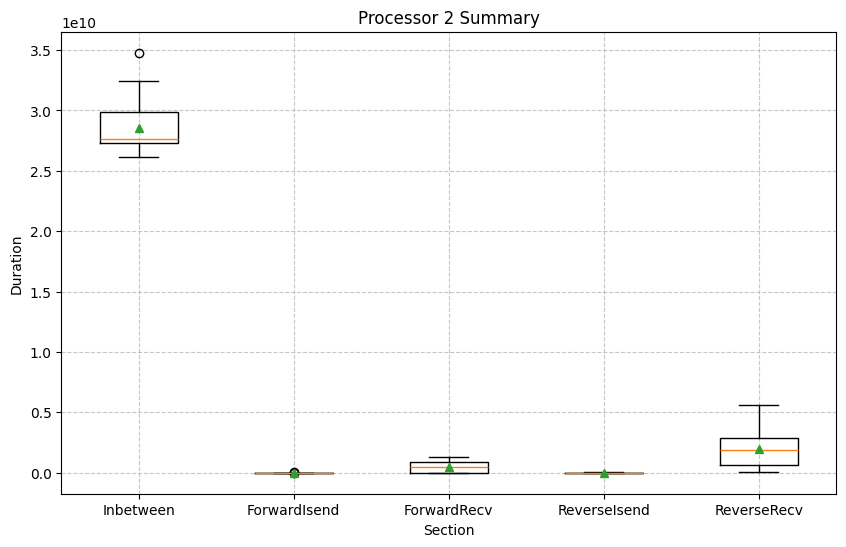

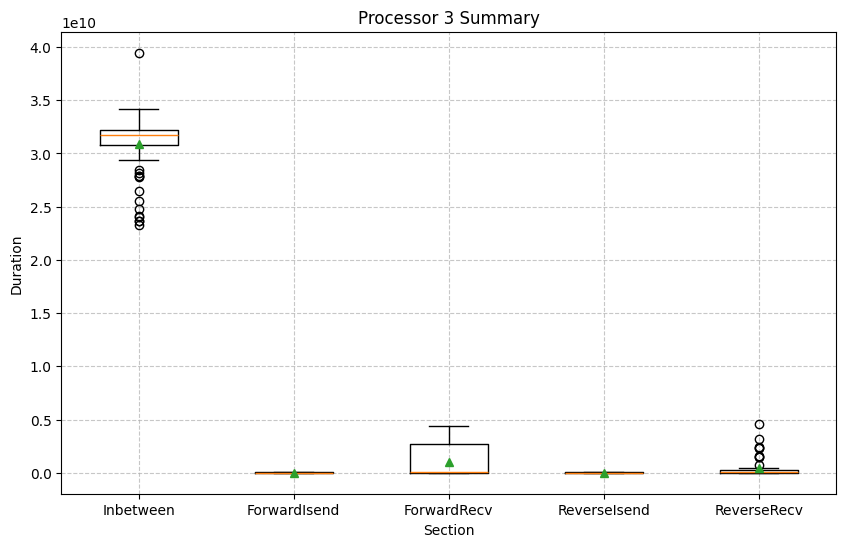

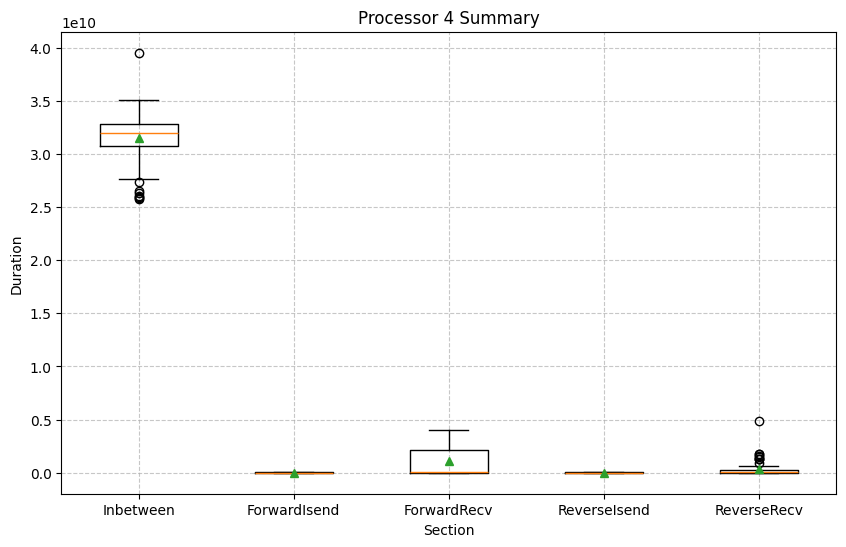

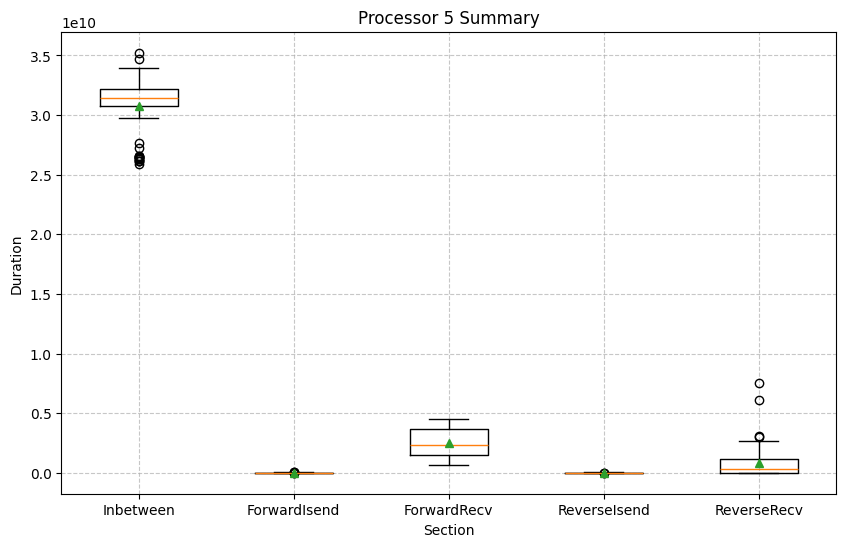

In [10]:
def plot_section_summary(data: list[pd.DataFrame], path: str = None):
    for processor_idx, df in enumerate(data):
        # Compute statistics for each section
        grouped = df.groupby("section")["duration"]
        sections = grouped.groups.keys()
        # Plot the "Inbetween" section separately since it outlies the rest
        if "Inbetween" in sections:
            sections = list(sections)
            sections.remove("Inbetween")
        durations = [grouped.get_group(sec) for sec in sections]

        # Create a box plot
        plt.figure(figsize=(10, 6))
        plt.boxplot(durations, tick_labels=sections, showmeans=True)

        # Titles and labels
        plt.title(f"Processor {processor_idx} Summary")
        plt.xlabel("Section")
        plt.ylabel("Duration")
        plt.grid(True, linestyle="--", alpha=0.7)
        if path:
            plt.savefig(f"{path}/processor_{processor_idx}.png")
            plt.savefig(f"{path}/processor_{processor_idx}.eps")


def plot_inbetween_summary(data: list[pd.DataFrame], path: str = None):
    sections = ["Inbetween", "ForwardIsend", "ForwardRecv", "ReverseIsend", "ReverseRecv"]
    for processor_idx, df in enumerate(data):
        grouped = df.groupby("section")["duration"]
        durations = [grouped.get_group(sec) for sec in sections]

        # Create a box plot
        plt.figure(figsize=(10, 6))
        plt.boxplot(durations, tick_labels=sections, showmeans=True)

        # Titles and labels
        plt.title(f"Processor {processor_idx} Summary")
        plt.xlabel("Section")
        plt.ylabel("Duration")
        plt.grid(True, linestyle="--", alpha=0.7)
        if path:
            plt.savefig(f"{path}/processor_{processor_idx}_inbetween.png")
            plt.savefig(f"{path}/processor_{processor_idx}_inbetween.eps")

# Plot the summary for all processors
os.makedirs("summaries", exist_ok=True)
plot_section_summary(timer_data, path="summaries")
plot_inbetween_summary(timer_data, path="summaries")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


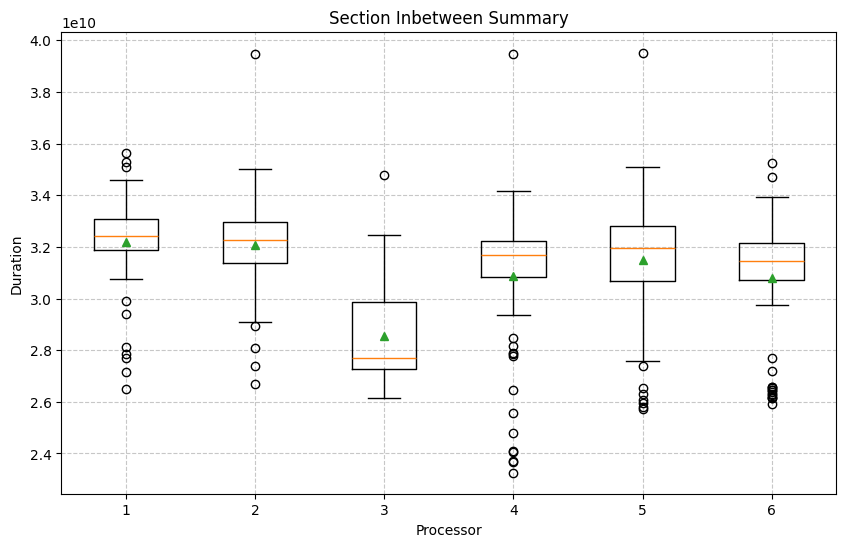

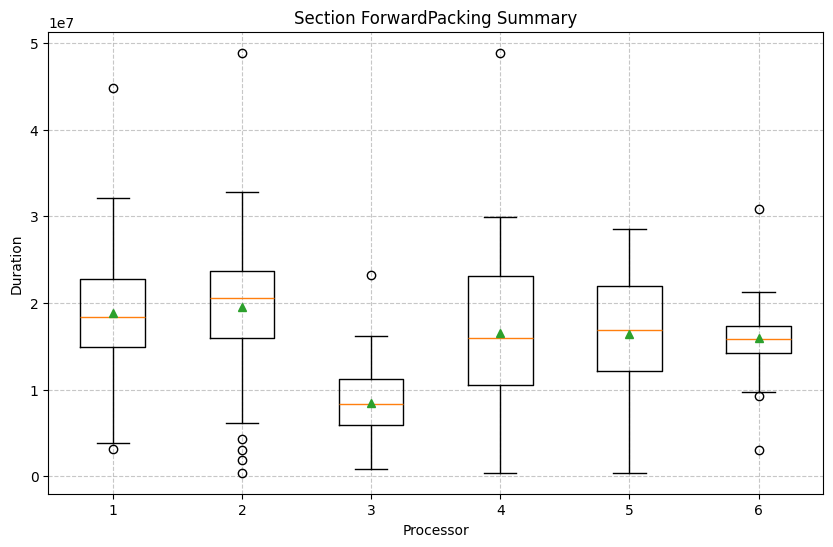

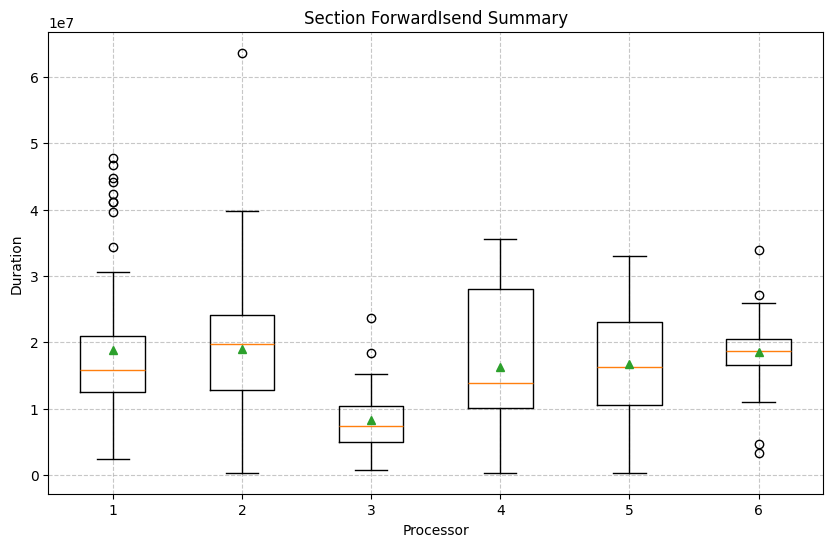

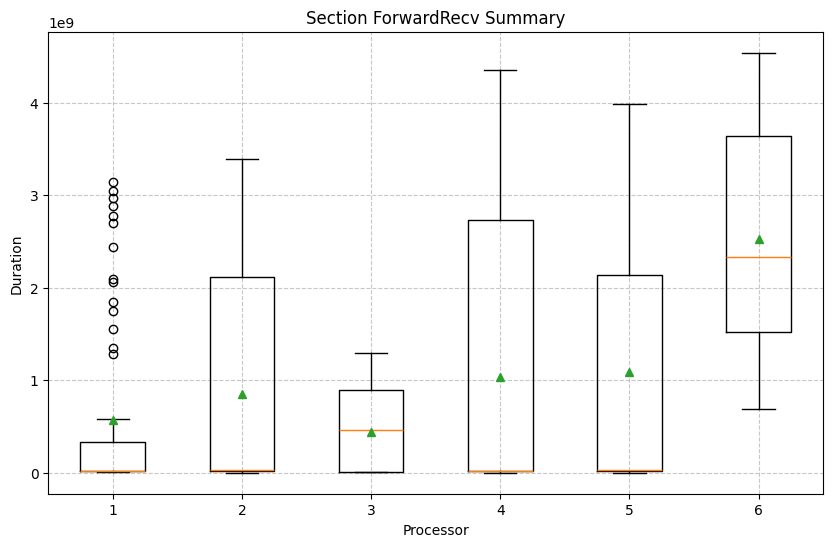

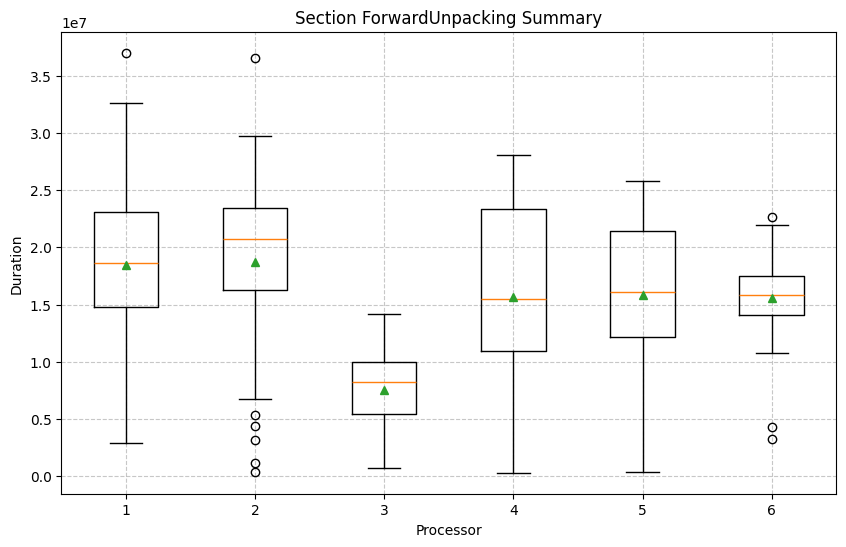

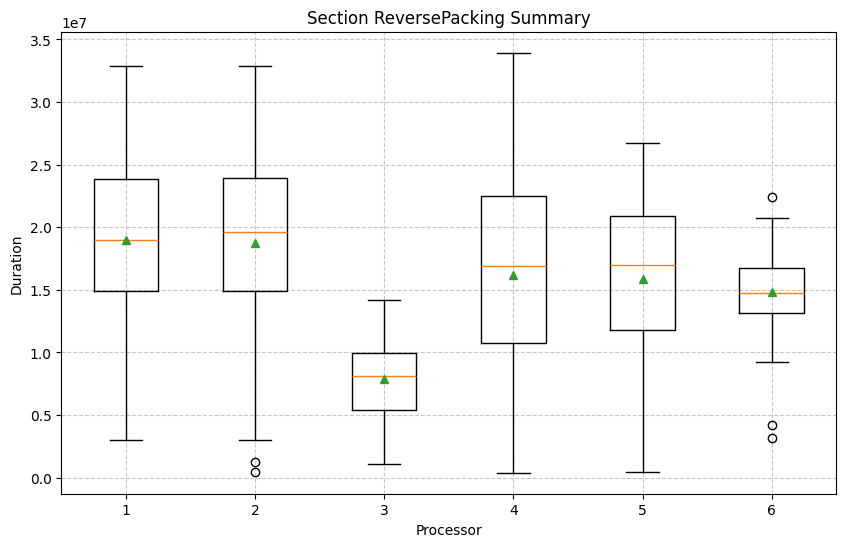

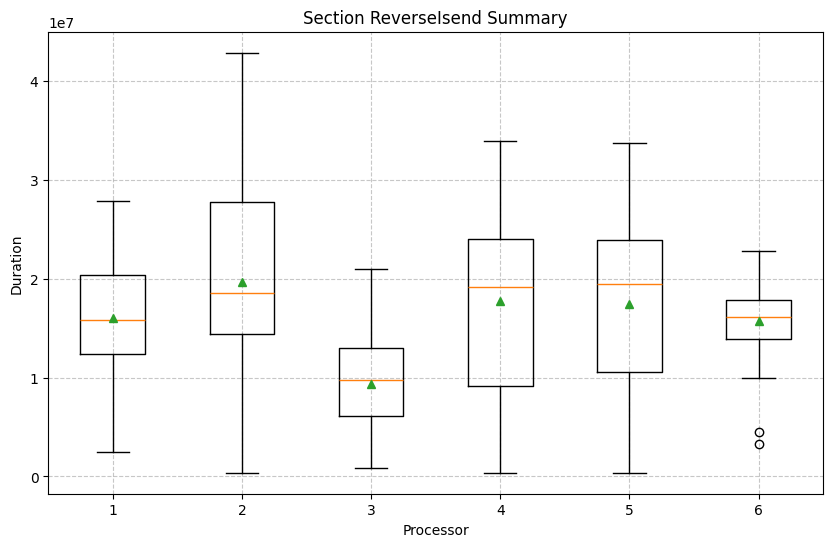

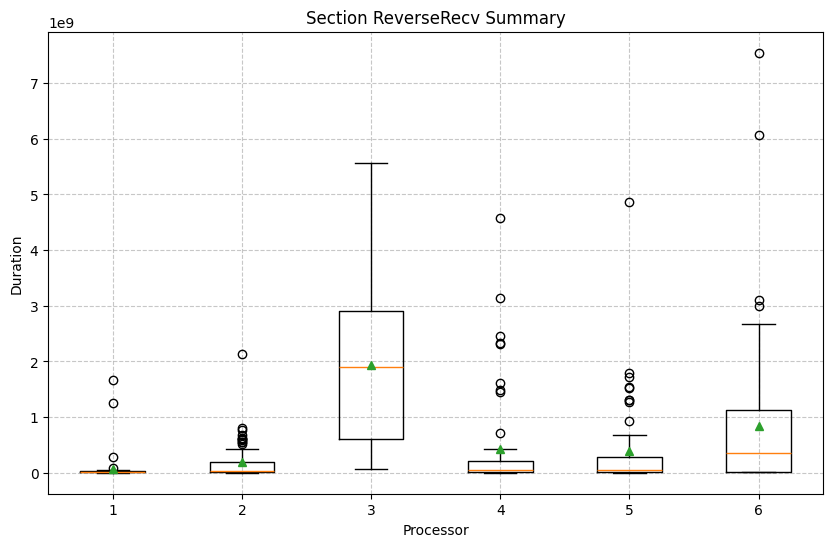

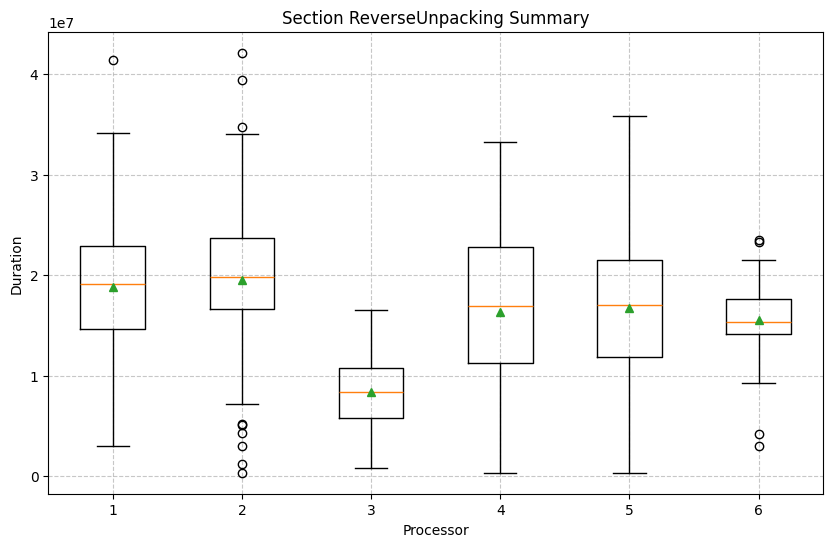

In [11]:
def plot_processor_summary(data: list[pd.DataFrame], path: str = None):
    for section in sections:
        # Collect data for the specified section
        section_data = [df[df["section"] == section]["duration"] for df in data]

        # Create a box plot
        plt.figure(figsize=(10, 6))
        plt.boxplot(section_data, showmeans=True)

        # Titles and labels
        plt.title(f"Section {section} Summary")
        plt.xlabel("Processor")
        plt.ylabel("Duration")
        plt.grid(True, linestyle="--", alpha=0.7)
        if path:
            plt.savefig(f"{path}/section_{section}.png")
            plt.savefig(f"{path}/section_{section}.eps")

# Plot the summary for all sections
plot_processor_summary(timer_data, path="summaries")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


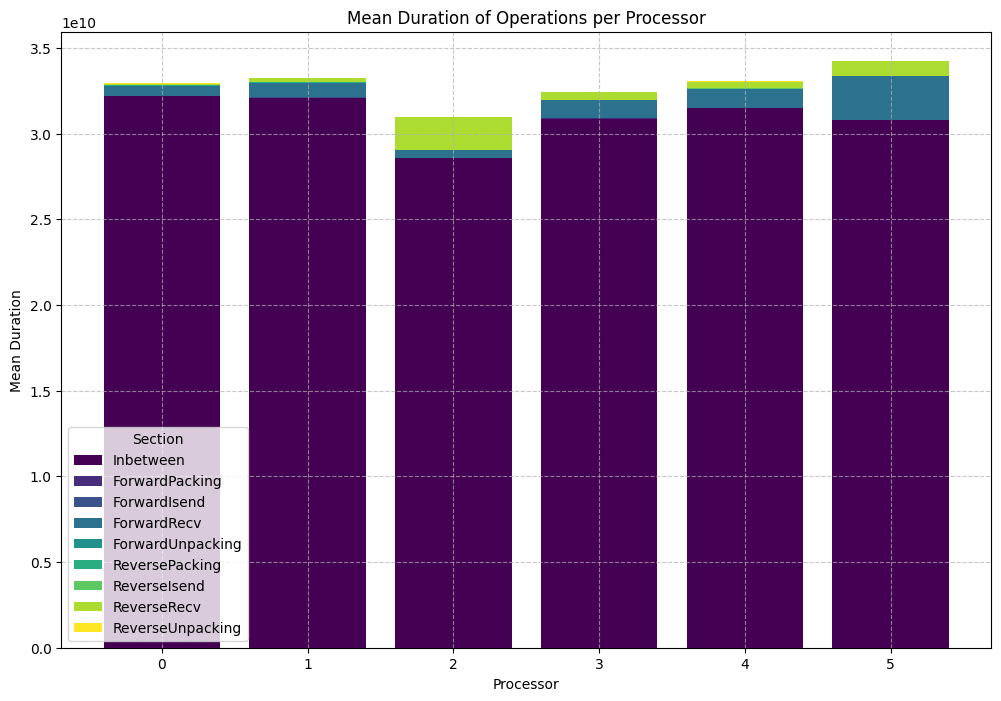

In [12]:
def plot_stacked_bar_chart(data: list[pd.DataFrame], sections: np.ndarray, path: str = None):
    # Initialize the figure
    plt.figure(figsize=(12, 8))

    # Number of processors
    nproc = len(data)

    # Initialize the bottom array for stacking
    bottom = np.zeros(nproc)

    # Colors for each section
    colors = plt.cm.viridis(np.linspace(0, 1, len(sections)))

    # Plot each section
    for section, color in zip(sections, colors):
        # Collect mean duration for the specified section
        mean_durations = [df[df["section"] == section]["duration"].mean() for df in data]

        # Plot the bar
        plt.bar(range(nproc), mean_durations, bottom=bottom, label=section, color=color)

        # Update the bottom array
        bottom += mean_durations

    # Titles and labels
    plt.title("Mean Duration of Operations per Processor")
    plt.xlabel("Processor")
    plt.ylabel("Mean Duration")
    plt.legend(title="Section")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot if path is provided
    if path:
        plt.savefig(f"{path}/stacked_bar_chart.png")
        plt.savefig(f"{path}/stacked_bar_chart.eps")

    # Show the plot
    plt.show()

# Plot the stacked bar chart
plot_stacked_bar_chart(timer_data, sections, path="summaries")

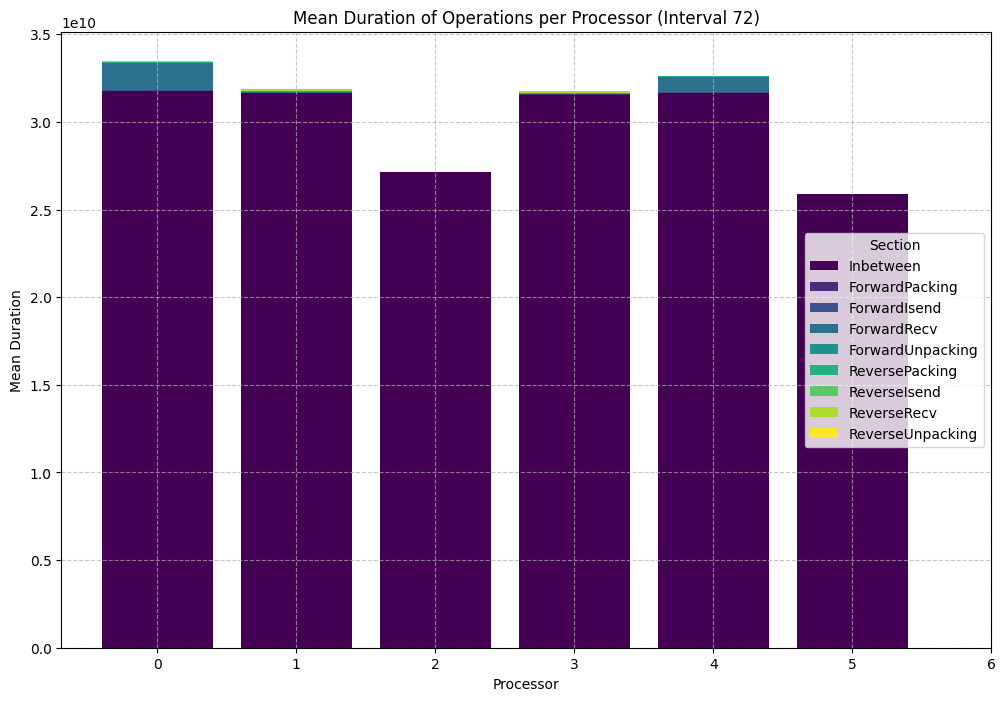

In [13]:
from matplotlib.animation import FuncAnimation

def animate_stacked_bar_chart(data: list[pd.DataFrame], sections: np.ndarray, path: str = None):
    # Number of processors
    nproc = len(data)

    # Colors for each section
    colors = plt.cm.viridis(np.linspace(0, 1, len(sections)))

    # Initialize the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    def update(interval):
        ax.clear()
        bottom = np.zeros(nproc)
        for section, color in zip(sections, colors):
            mean_durations = [
                df[(df["section"] == section) & (df["interval"] == interval)]["duration"].mean()
                for df in data
            ]
            ax.bar(range(nproc), mean_durations, bottom=bottom, label=section, color=color)
            bottom += mean_durations

        ax.set_title(f"Mean Duration of Operations per Processor (Interval {interval})")
        ax.set_xlabel("Processor")
        ax.set_xticks(range(7))
        ax.set_xticklabels(range(7))
        ax.set_ylabel("Mean Duration")
        ax.legend(title="Section", loc="center right")
        ax.grid(True, linestyle="--", alpha=0.7)

    ani = FuncAnimation(fig, update, frames=range(1, data[0]["interval"].max() + 1), repeat=False)

    if path:
        ani.save(f"{path}/stacked_bar_chart_animation.gif", writer="imagemagick")

    plt.show()

# Animate the stacked bar chart
animate_stacked_bar_chart(timer_data, sections, path="summaries")